<a href="https://colab.research.google.com/github/chaitra0312/ML/blob/main/Present.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance pandas numpy scikit-learn tensorflow xgboost matplotlib


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define multiple stock tickers (You can change these)
tickers = ["AAPL", "GOOGL", "AMZN", "TSLA"]  # Example smaller companies

# Download data from Yahoo Finance
data_dict = {}
for ticker in tickers:
    data_dict[ticker] = yf.download(ticker, start="2015-01-01", end="2024-01-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
scalers = {}  # Store scalers for each stock
train_data_dict, test_data_dict = {}, {}

for ticker in tickers:
    prices = data_dict[ticker][["Close"]].values  # Extract closing prices

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0,1))
    prices_scaled = scaler.fit_transform(prices)
    scalers[ticker] = scaler  # Store the scaler for later

    # Split into train/test (80% training, 20% testing)
    train_size = int(len(prices_scaled) * 0.8)
    train_data, test_data = prices_scaled[:train_size], prices_scaled[train_size:]

    train_data_dict[ticker] = train_data
    test_data_dict[ticker] = test_data

In [3]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # Use past 60 days for prediction

X_train_dict, y_train_dict, X_test_dict, y_test_dict = {}, {}, {}, {}

for ticker in tickers:
    X_train, y_train = create_sequences(train_data_dict[ticker], seq_length)
    X_test, y_test = create_sequences(test_data_dict[ticker], seq_length)

    # Reshape for LSTM & GRU
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    X_train_dict[ticker], y_train_dict[ticker] = X_train, y_train
    X_test_dict[ticker], y_test_dict[ticker] = X_test, y_test

print("Data preparation done for all stocks!")


Data preparation done for all stocks!


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

# Function to create LSTM model
def create_lstm_model():
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(60, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)  # Predicting one future value
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
# Function to create GRU model
def create_gru_model():
    model = Sequential([
        GRU(50, return_sequences=True, input_shape=(60, 1)),
        Dropout(0.2),
        GRU(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [5]:
lstm_models, gru_models = {}, {}

for ticker in tickers:
    print(f"Training models for {ticker}...")

    # Create LSTM & GRU models
    lstm_model = create_lstm_model()
    gru_model = create_gru_model()

    # Train LSTM model
    lstm_model.fit(X_train_dict[ticker], y_train_dict[ticker], epochs=20, batch_size=16, validation_data=(X_test_dict[ticker], y_test_dict[ticker]), verbose=1)

    # Train GRU model
    gru_model.fit(X_train_dict[ticker], y_train_dict[ticker], epochs=20, batch_size=16, validation_data=(X_test_dict[ticker], y_test_dict[ticker]), verbose=1)

    # Store trained models
    lstm_models[ticker] = lstm_model
    gru_models[ticker] = gru_model

print("LSTM & GRU training completed for all stocks!")


Training models for AAPL...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 0.0315 - val_loss: 0.0013
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 8.2177e-04 - val_loss: 0.0017
Epoch 9/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 9.4398e-04 - val_loss: 0.0024
Epoch 11/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 8.3095e-04 - val_loss: 0.0014
Epoch 12/20
110/110 ━━━━

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xgb_models = {}

for ticker in tickers:
    print(f"Training XGBoost for {ticker}...")

    # Get LSTM & GRU predictions on training and testing data
    lstm_train_pred = lstm_models[ticker].predict(X_train_dict[ticker])
    lstm_test_pred = lstm_models[ticker].predict(X_test_dict[ticker])

    gru_train_pred = gru_models[ticker].predict(X_train_dict[ticker])
    gru_test_pred = gru_models[ticker].predict(X_test_dict[ticker])

    # Combine LSTM & GRU predictions as XGBoost input
    X_train_xgb = np.concatenate((lstm_train_pred, gru_train_pred), axis=1)
    X_test_xgb = np.concatenate((lstm_test_pred, gru_test_pred), axis=1)

    # Train XGBoost
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
    xgb_model.fit(X_train_xgb, y_train_dict[ticker])

    # Store trained XGBoost model
    xgb_models[ticker] = xgb_model

print("XGBoost training completed for all stocks!")


Training XGBoost for AAPL...
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Training XGBoost for GOOGL...
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Training XGBoost for AMZN...
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Training XGBoost for TSLA...
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
XGBoost training completed for all stocks!


Evaluating model for AAPL...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
AAPL RMSE: 7.70183598865723


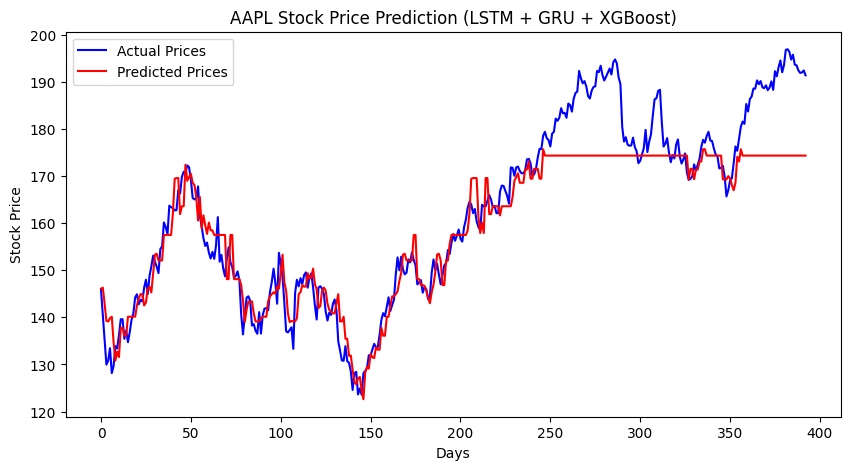

Evaluating model for GOOGL...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
GOOGL RMSE: 4.148560861496183


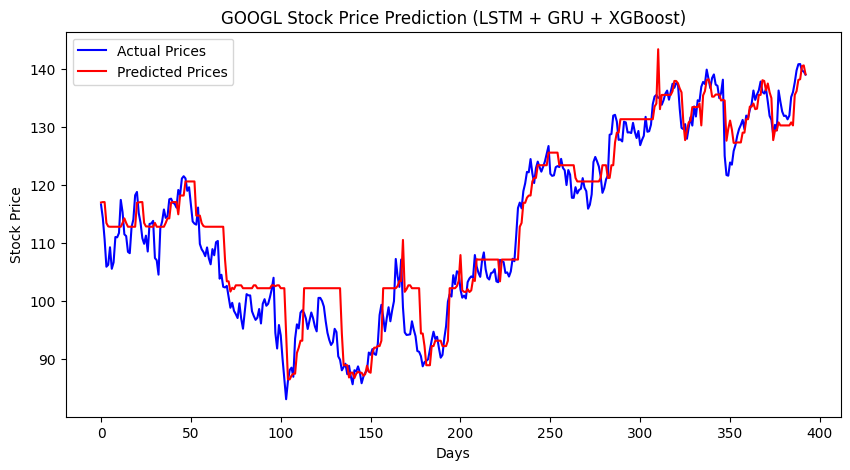

Evaluating model for AMZN...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AMZN RMSE: 4.83923770762893


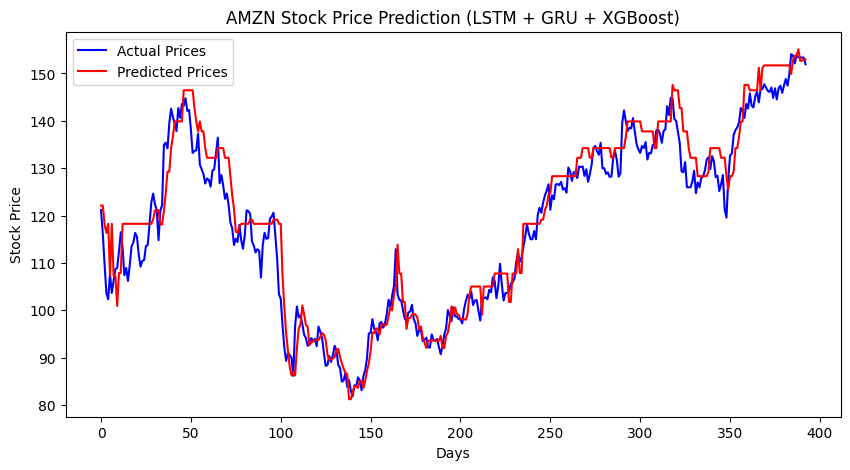

Evaluating model for TSLA...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
TSLA RMSE: 10.628285199703521


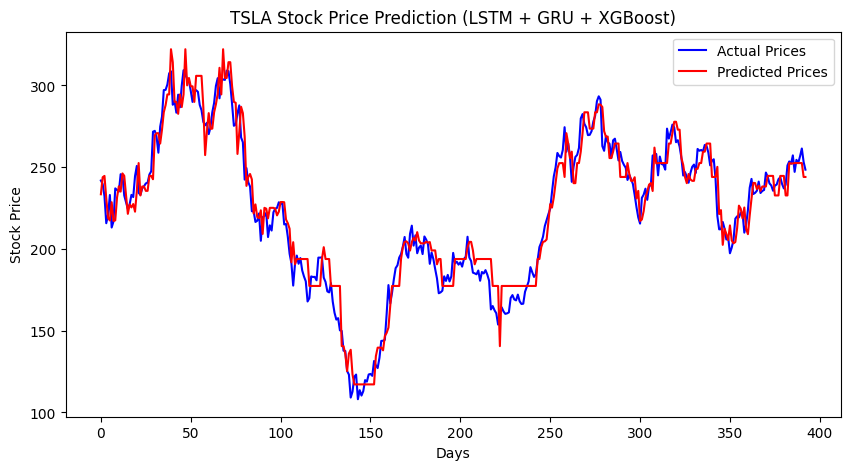

In [7]:
for ticker in tickers:
    print(f"Evaluating model for {ticker}...")

    # Get test set predictions from trained XGBoost model
    lstm_test_pred = lstm_models[ticker].predict(X_test_dict[ticker])
    gru_test_pred = gru_models[ticker].predict(X_test_dict[ticker])
    X_test_xgb = np.concatenate((lstm_test_pred, gru_test_pred), axis=1)

    final_predictions = xgb_models[ticker].predict(X_test_xgb)

    # Rescale predictions back to original prices
    final_predictions_rescaled = scalers[ticker].inverse_transform(final_predictions.reshape(-1, 1))
    actual_prices = scalers[ticker].inverse_transform(y_test_dict[ticker].reshape(-1, 1))

    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(actual_prices, final_predictions_rescaled))
    print(f"{ticker} RMSE: {rmse}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(10, 5))
    plt.plot(actual_prices, label="Actual Prices", color='blue')
    plt.plot(final_predictions_rescaled, label="Predicted Prices", color='red')
    plt.title(f"{ticker} Stock Price Prediction (LSTM + GRU + XGBoost)")
    plt.xlabel("Days")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


In [8]:
# Save LSTM model
lstm_model.save('lstm_model.h5')

# Save GRU model
gru_model.save('gru_model.h5')


In [9]:
# Save LSTM model
lstm_model.save("lstm_model.keras")

# Save GRU model
gru_model.save("gru_model.keras")


In [10]:
import pickle

# Save XGBoost model
with open("xgboost_model.pkl", "wb") as file:
    pickle.dump(xgb_model, file)


In [11]:
from google.colab import files

# Download LSTM Model
files.download('lstm_model.h5')

# Download GRU Model
files.download('gru_model.h5')

# Download XGBoost Model
files.download('xgboost_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>